In [1]:

import numpy as np
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
# from mpl_toolkits.basemap import Basemap
import glob
from netCDF4 import Dataset
import copy
import gc

import os
import sys
# sys.path.insert(0, '/Users/h/Github/geo_data_group/')
import grid_set as gs

import ant_plus
from imp import reload
reload(ant_plus)
reload(gs)

<module 'grid_set' from '/Users/h/PREMELT/Ant+/grid_set.py'>

In [2]:
#$### map projection
m = ccrs.SouthPolarStereo()
proj_cart = ccrs.PlateCarree() 
f = plt.figure()
G= gs.grid_set(m)

ax = f.add_subplot(1,1,1,projection=m)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
G.set_grid_dxy(50e3,50e3,ax)
plt.close()


Got a grid res =  185  x  185
Note that all grid info is in nx x ny grids, whilst data is in nx x ny


In [2]:
file = 'Example_Merge/Open_ocean_ANOM_2019-09-01T00-03_2019-09-03T23-26.nc'
track=ant_plus.CS2_track(file,add_attr=True)
track.print_time()

2019-09-01T00:03:28.418137--2019-09-03T23:26:34.553547


In [3]:
### makes a directory for figures
fig_dir = file.split('.nc')[0]+'/'
check_dir = os.path.dirname(fig_dir)
if not os.path.exists(check_dir):
    os.makedirs(check_dir)

In [4]:
track.list_vars()#['ANOM','flag',])

['time_20_ku',
 'lon_20_ku',
 'lat_20_ku',
 'range_1_20_ku_ANOM_CLS_LEAD',
 'range_1_20_ku_ANOM_MSSL_D',
 'range_1_20_ku_ANOM_MSSL_S',
 'range_1_20_ku_ANOM_DTU_gauss',
 'range_1_20_ku_ANOM_DTU_th70',
 'range_1_20_ku_ANOM_DTU_imp_th70',
 'mean_sea_surf_20_ku_ANOM_DTU15',
 'ocean_tide_20_ku_ANOM_DTU_fes',
 'range_1_20_ku_ANOM_ISat_2step',
 'atm_geo_corrections_sum_ANOM_ISat']

In [73]:
load_list = track.list_vars(['ANOM','flag','height','geoid'])
# load_list = track.list_vars(['mean'])
track.add_vars(load_list)

In [71]:
# track.mean_sea_surf_20_ku_ANOM_DTU15_attr
track.flag_surf_type_class_20_ku_attr

{'comment': 'Flag indicating the surface type determined by analysis of the waveform and aux values. Unused in LRM mode. Over ocean in SARIn mode, the SAR discriminator for sea ice is used.',
 'coordinates': 'lon_20_ku lat_20_ku',
 'flag_mask': array([  1,   2,   4,   8,  16,  32,  64, 128, 256], dtype=int16),
 'flag_meanings': 'lrm_undefined lrm_ocean lrm_land_ice sarin_undefined sarin_valid sar_undefined sar_ocean sar_sea_ice sar_lead',
 'long_name': 'discriminated surface type'}

In [44]:
# track.mean_sea_surf_20_ku_ANOM_DTU15_attr
track.flag_surf_type_20_ku_CLS_attr

{'coordinates': 'lon_20_ku lat_20_ku',
 'flag_values': '0b, 1b, 2b , 3b',
 'flag_meanings': 'unknown/mixed ocean sea_ice lead',
 'long_name': 'surface type flag',
 'comment': 'A 4-state surface type mask for Cryosat2 data from the LEGOS GPOD along track data.Flag file converted from the three original supplied flag files: flag_floes_meas_valid_20hz,flag_leads_meas_valid_20hz,flag_open_ocean_meas_valid_20h'}

In [16]:
np.sum(track.flag_surf_type_class_20_ku <128)

777525

In [24]:
np.maximum(np.abs(h_min),np.abs(h_max))

0.9060000000754371

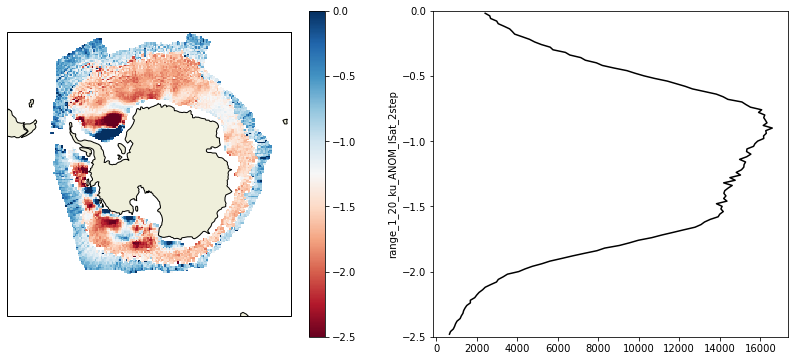

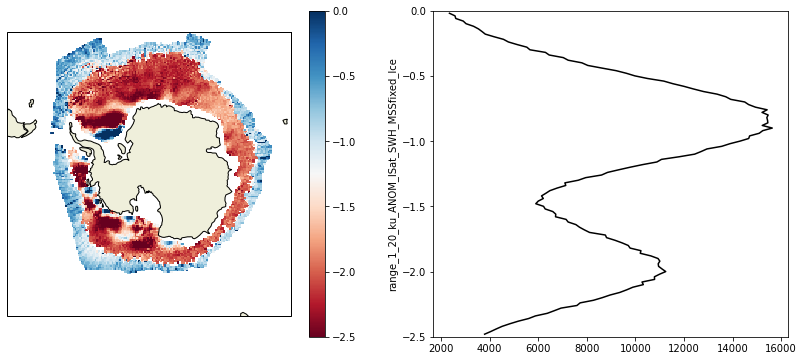

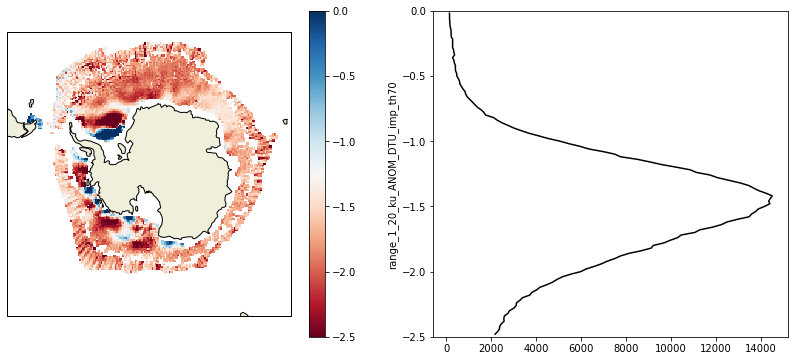

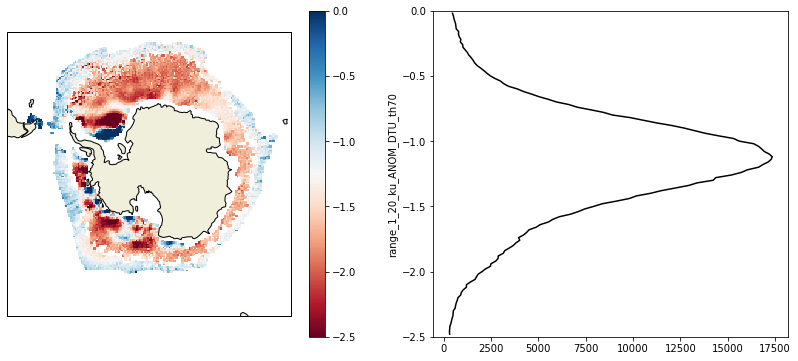

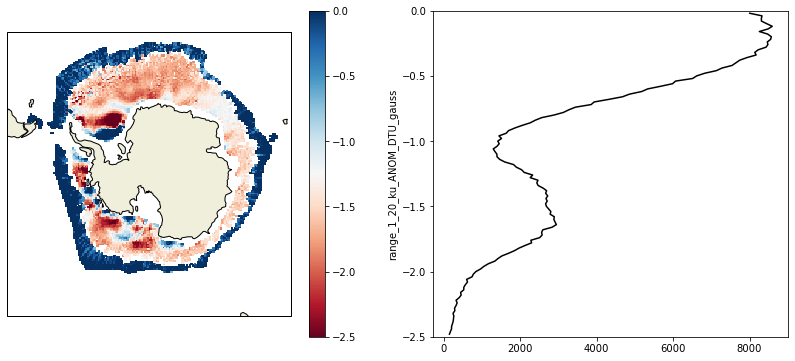

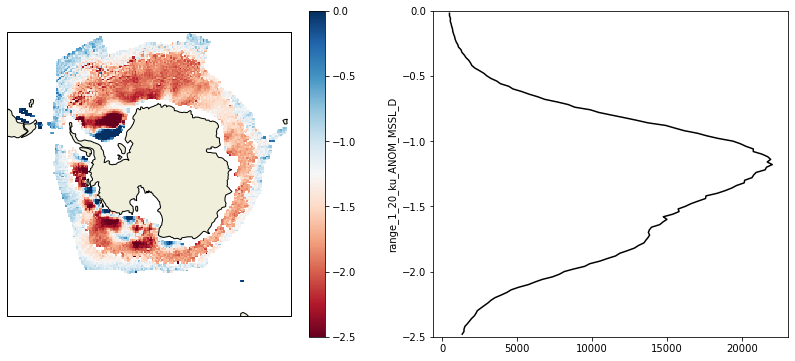

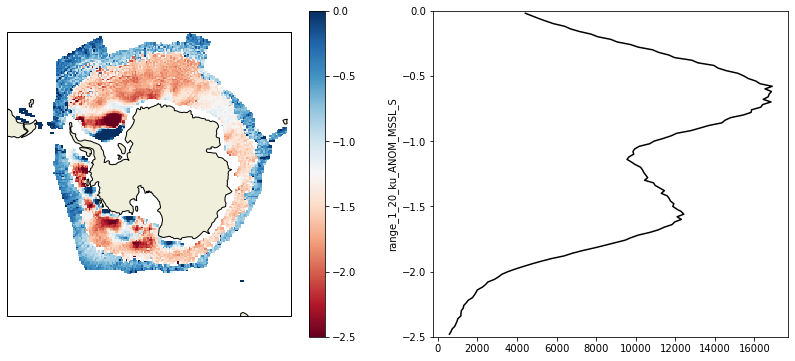

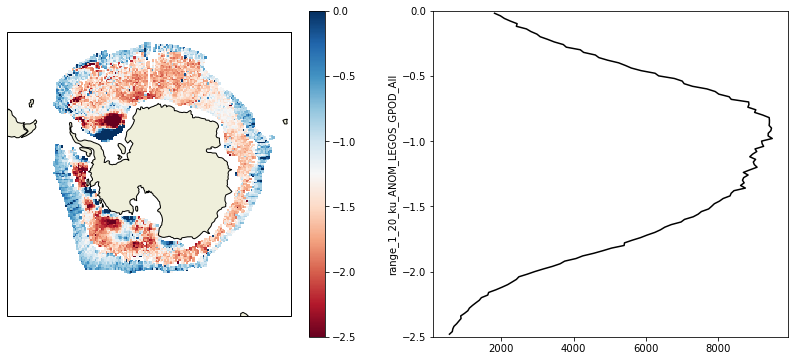

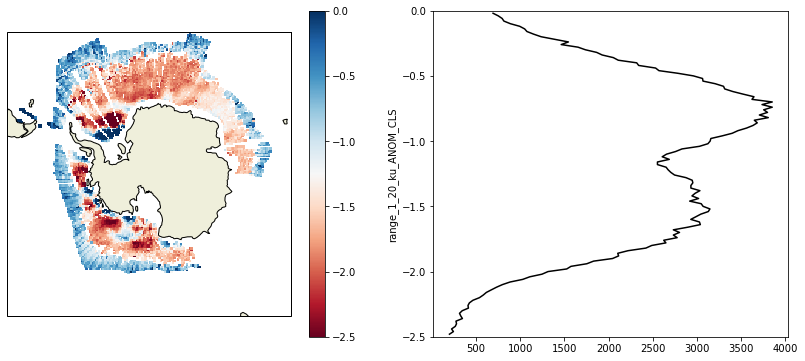

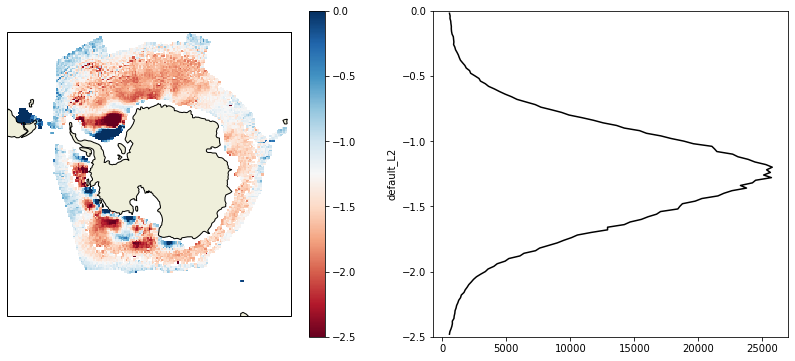

In [66]:
# p_vars = [p for p in track.vars if 'LEGOS' in p and 'flag' not in p]
p_vars = [p for p in track.vars if 'ANOM' in p ]
# p_vars = [p for p in track.vars if 'DTU' in p and 'LEGOS' not in p]
# p_vars = [p for p in track.vars if 'flag' in p]
# p_vars = [p for p in track.vars if 'atm' in p and 'flag' not in p]
SaveT = 'DOT_'
h_bins = np.arange(-0.8,0.8,0.02)
p_vars = p_vars+['default_L2'] #### extra for not adding an anomally
h_auto = False
h_sym = False
h_trim = False ### centiles to knock off
h_min = -2.5
h_max =  0.0
# h_min = 0.9
# h_max =  3.1
hard_min = -10.0
hard_max =  10.0
LG_CLS_flag = 2
msk = track.flag_surf_type_class_20_ku ==  128
# msk[track.flag_surf_type_class_20_ku ==  64] = True
h_bins = np.arange(h_min,h_max,0.02)
for v in p_vars:
#     x = getattr(track,v).copy()
    if 'default' in v: #### to make DOT
        x = track.height_1_20_ku - track.geoid_20_ku
    else:
        x = getattr(track,v).copy()
        #### to make DOT
        x = x + track.height_1_20_ku - track.geoid_20_ku
    #### extra masking
    if 'GPOD' in v:
        msk[track.flag_surf_type_20_ku_LEGOS_GPOD==LG_CLS_flag] = 0
    if 'CLS' in v:
        msk[track.flag_surf_type_20_ku_CLS==LG_CLS_flag] = 0
#     if 'class' in v:
#         x[x<64] = 0
#         x[x==256] = 3
#         x[x==128] = 2
#         x[x==64] = 1
    x[x.mask] = np.nan
    msk[x>hard_max] = 0
    msk[x<hard_min] = 0
    if h_trim:
        h_t0,h_t1 = np.nanpercentile(x[msk],[h_trim,100-h_trim])
        msk[x>h_t1] = 0
        msk[x<h_t0] = 0
        
    x = x[msk]
        
    plot_array  = G.bin_list(x,#track.mean_sea_surf_20_ku_ANOM_LEGOS_GPOD_DTU15,
                            track.lon_20_ku[msk],track.lat_20_ku[msk],xy_order=0)
#                              bin_func = func_u)
    if h_auto:
        h_min,h_max = np.nanpercentile(x,[0.5,99.5])
        if h_sym:
            h_max = np.maximum(np.abs(h_min),np.abs(h_max))
            h_min = -h_max
        h_bins = np.arange(h_min,h_max,(h_max-h_min)/50)

    f = plt.figure(figsize=[14,6])
    ax = f.add_subplot(1,2,1,projection=m)
    ax.set_extent([-180, 180, -90, -50], proj_cart)
    s = ax.pcolormesh(G.xpts,G.ypts,plot_array,
                     cmap = 'RdBu',vmin = h_min,vmax = h_max)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    plt.colorbar(s,shrink=1.0,pad=0.05)
    
    ax = f.add_subplot(1,2,2)
    hist = np.histogram(x,bins=h_bins)[0]
#     ax.plot(h_bins[:-1] + np.diff(h_bins),hist,'-k')
    ax.plot(hist,h_bins[:-1] + np.diff(h_bins),'-k')
    ax.set_ylim([h_min,h_max])
    ax.set_ylabel(v)
#     f.savefig(fig_dir+SaveT+v+'_map_hist.png',bbox_inches='tight')

    plt.show()

In [74]:
for v in track.vars:
#     if 'range' in v and 'ANOM' not in v:
#     if 'range' in v and 'ISat' in v:
    if 'geoi' in v:
#     if 'ANOM' in v:
        print('-----')
        print(v)
        print('-----')
        if hasattr(track,v+'_attr'):
            attr = getattr(track,v+'_attr')
            for key, value in attr.items():
                print(key, ' : ', value)
        x = copy.copy(getattr(track,v))
        if type(x.mask) == np.ndarray:
            x[x.mask] = np.nan
        print('Distribution of '+v+' = '+' , '.join('{:.3}'.format(pc) for pc in np.nanpercentile(x,[25,50,75])))

-----
geoid_20_ku
-----
comment  :  Computed from the geoid model with a correction to refer the value to the mean tide system i.e. includes the permanent tide (zero frequency),and referenced to WGS84. See Lemoine, F. G., S. C. Kenyon, J. K. Factor, R.G. Trimmer, N. K. Pavlis, D. S. Chinn, C. M. Cox, S. M. Klosko, S. B. Luthcke, M. H. Torrence, Y. M. Wang, R. G. Williamson, E. C. Pavlis, R. H. Rapp and T. R. Olson (1998). The Development of the Joint NASA GSFC and the National Imagery and Mapping Agency (NIMA) Geopotential Model EGM96. NASA/TP-1998-206861, July 1998.
coordinates  :  lon_20_ku lat_20_ku
institution  :  NASA GSFC and NIMA
long_name  :  geoid height
scale_factor  :  0.001
source  :  EGM96
standard_name  :  geoid_height_above_reference_ellipsoid
units  :  m
Distribution of geoid_20_ku = -36.2 , 5.38 , 19.2
